Since we use the shortest path to determine voltage input above, it is important to check we aren't missing characteristics of the networks under different voltages. Therefore we perform a voltage sweep with the maximum and minimum accuracy networks, to see if they can peform better/worse under different circumstances.

In [3]:
cd "/suphys/aloe8475"


/suphys/aloe8475


In [4]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [5]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

#warnings.filterwarnings('ignore')

In [6]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [7]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [8]:
name='networks_LinearTransformation.pkl'
print('Loading Networks')
file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
[ASN300] = pickle.load(file)


Loading Networks


In [9]:
#Calculate nodesList
nodesList=[[None]*10 for i in range(len(ASN300))]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])): #for each network:
        if len(ASN300[i][j]['G']) >= 250:
            nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
        elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
            nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
            nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
            nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)

## Initial Voltage Values

In [10]:
ASNaccuracy=[[[None]*len(ASN300[0]) for j in range(len(ASN300))] for i in range(len(nodesList[0][-1]))]


for i in range(len(ASN300)): #for each parameter
    temp=[]
    for j in range(len(ASN300[i])): # for each network
        for k in range(len(ASN300[i][j]['Accuracy']['Linear Transformation'])):
            temp=ASN300[i][j]['Accuracy']['Linear Transformation'][k]
            if k == 0:
                ASNaccuracy[k][i][j]=temp
            elif k == 1:
                ASNaccuracy[k][i][j]=temp
            elif k == 2:
                ASNaccuracy[k][i][j]=temp
            elif k == 3:
                ASNaccuracy[k][i][j]=temp
            elif k == 4:
                ASNaccuracy[k][i][j]=temp
            elif k == 5:
                ASNaccuracy[k][i][j]=temp
                
#Find top 50 accuracy and bottom 50 accuracy networks
count=0
accuracy=[None]*300
for i in range(len(ASNaccuracy[-1])):
    for j in range(len(ASNaccuracy[-1][i])):
        accuracy[count]=ASNaccuracy[-1][i][j]
        count=count+1

idx_acc=np.argsort(accuracy)
accuracy2=np.sort(accuracy)
min_idx_acc=idx_acc[0:50]
min_accuracy=accuracy2[0:50]
max_idx_acc=idx_acc[-50:]
max_accuracy=accuracy2[-50:]

MaxAcc=[]        
for i in range(len(max_idx_acc)):
    if max_idx_acc[i] >= 100: 
        MaxAcc.append([int(float(max_idx_acc[i])/10),list(map(int, str(max_idx_acc[i])))[-1]])
    elif max_idx_acc[i] <10: 
        MaxAcc.append([0, list(map(int, str(max_idx_acc[i])))[-1]])
    else:
        MaxAcc.append(list(map(int, str(max_idx_acc[i]))))

MinAcc=[]        
for i in range(len(min_idx_acc)):
    if min_idx_acc[i] >= 100: 
        MinAcc.append([int(float(min_idx_acc[i])/10),list(map(int, str(min_idx_acc[i])))[-1]])
    elif min_idx_acc[i] <10: 
        MinAcc.append([0, list(map(int, str(min_idx_acc[i])))[-1]])
    else:
        MinAcc.append(list(map(int, str(min_idx_acc[i]))))
#3 Plot Networks on Graph:


In [11]:
#Shortest Path for 3D Plot
onAmpVi=[[] for i in range(len(ASN300))]
shortestPath=[[None]*10 for i in range(len(ASN300))]
for i in tqdm(range(len(ASN300))):
    for j in range(len(ASN300[i])):
        temp=getFarthestPairing(ASN300[i][j]['adj_matrix'])
        shortestPath[i][j]=nx.shortest_path_length(ASN300[i][j]['G'],temp[0],temp[1])
        onAmpVi[i].append(shortestPath[i][j]/5) #need to justify divide by 5 or come up with some other way

In [12]:
Max_shortestPath=[]
Min_shortestPath=[]
Max_Vi=[]
Min_Vi=[]
for i in range(len(MaxAcc)):
    Max_shortestPath.append(shortestPath[MaxAcc[i][0]][MaxAcc[i][1]])
    Min_shortestPath.append(shortestPath[MinAcc[i][0]][MinAcc[i][1]])
    Max_Vi.append(onAmpVi[MaxAcc[i][0]][MaxAcc[i][1]])
    Min_Vi.append(onAmpVi[MinAcc[i][0]][MinAcc[i][1]])

## Start Voltage sweep

In [13]:
Max_Min_NWS=np.vstack([MaxAcc, MinAcc])
onAmp_MinMax=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]

In [14]:
def voltSweep(onAmp_MinMax,Max_Min_NWS,ASN300,results_minMax,nodesList,i,j):
    #for each network
    stimulus=[[],[]]
    dt = 1e-2
    f=0.5
    Time=5

    #Choose Electrode Pattern

    stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp_MinMax[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    #Initialise Output Variables
    period=[]
    TimeVector=[]
    voltage=[]
    conductance=[]
    switches=[]
    # Voltage=[None]*len(ASN300)
    # Switches=[None]*len(ASN300)

    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#         if j < 50:
#             print('Voltage ' + str(onAmp_MinMax[i]) +', Max Accuracy ' + str(j))
#         else:
#             print('Voltage ' + str(onAmp_MinMax[i]) +', Min Accuracy'  + str(j))
    results_minMax=runSim(connectivity__(wires_dict=ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp_MinMax[i], biasType='AC',f=f,junctionMode='tunneling')
     #100 simulations
    results_minMax.frequency=f
    results_minMax.dt=0.001
    period=1/f

    TimeVector=results_minMax.TimeVector
    voltage=results_minMax.wireVoltage
    conductance=results_minMax.conductance
    switches=results_minMax.junctionSwitch

    if len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 250:
        nodesList=[50,100,150,200,250,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 200 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 250:
        nodesList=[50,100,150,200,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 150 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 200:
        nodesList=[50,100,150,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 100 and len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) < 150:
        nodesList=[50,100,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)

    nwSqu =[None]*len(nodesList)

    target1= (onAmp_MinMax[i] * (-np.sign(TimeVector % period - period/2)))

    countK=0
    for k in nodesList: #loop through sets of nodes for regression
        print('Running Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_minMax,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)

    # OLD WAY: NOKEVregression(target1[j],nwOutputs[j].T)[0]
    # OLD WAY: outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
    # temp=np.dot(outputx,ResultSqu)
    # MSE=np.mean((target1[j]-temp)**2)
    # rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
        nwSqu[countK]=ResultSqu['accuracy']
        countK=countK+1   
    return nwSqu
#     name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50_Max_Min_NWs_Simulations_Voltage_' + str(onAmp_MinMax[i])
#     print('Saving Simulations for Voltage ' +str(i+1))
#     compressed_pickle([results_minMax],name)

In [15]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_networks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    initMax=[]
    initMin=[]
    for i in tqdm(range(len(onAmp_MinMax))): #for each voltage
        results_minMax=[None]*len(Max_Min_NWS)
        nodesList=[None]*len(Max_Min_NWS)
        for j in range(len(Max_Min_NWS)): #for each network
            if j<50:
                initMax.append(inputPacker(voltSweep,onAmp_MinMax,Max_Min_NWS,ASN300,results_minMax,nodesList,i,j))
            else:
                initMin.append(inputPacker(voltSweep,onAmp_MinMax,Max_Min_NWS,ASN300,results_minMax,nodesList,i,j))

In [16]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_networks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    resultMax=para_run(voltSweep,initMax,nCPU=15)   
    resultMin=para_run(voltSweep,initMin,nCPU=15)   



In [17]:
#Save networks so we don't have to run this every time  
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_networks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    print('Saving Max Min Accuracies')
    with open(name, 'wb') as f:
        pickle.dump([resultMax,resultMin], f)   
    print('Saved')
else:
    print('Loading ASN Max Min Accuracies')
    file = open(name, 'rb')
    [resultMax,resultMin] = pickle.load(file)
    print('Loaded')

Loading ASN Max Min Accuracies
Loaded


In [18]:
maxAcc=[]
minAcc=[]
for i in range(len(resultMax)): #for each network:
    tempMax=np.max(resultMax[i])
    tempMin=np.max(resultMin[i])
    maxAcc.append(tempMax)
    minAcc.append(tempMin)
    
maxAcc=np.vstack(maxAcc).reshape(11,50)
minAcc=np.vstack(minAcc).reshape(11,50)

In [19]:
vol1=[];vol2=[];vol3=[];vol4=[];vol5=[];vol6=[];vol7=[];vol8=[];vol9=[];vol10=[];vol11=[];
vol1_max=[];vol2_max=[];vol3_max=[];vol4_max=[];vol5_max=[];vol6_max=[];vol7_max=[];vol8_max=[];vol9_max=[];vol10_max=[];
vol11_max=[];

for i in range(len(minAcc)):
    for j in range(len(minAcc[i])):
        if i==0:
            vol1_max.append(maxAcc[i][j])
            vol1.append(minAcc[i][j])
        elif i == 1:
            vol2_max.append(maxAcc[i][j])
            vol2.append(minAcc[i][j])
        elif i == 2:
            vol3_max.append(maxAcc[i][j])
            vol3.append(minAcc[i][j])
        elif i == 3:
            vol4_max.append(maxAcc[i][j])
            vol4.append(minAcc[i][j])
        elif i == 4:
            vol5_max.append(maxAcc[i][j])
            vol5.append(minAcc[i][j])
        elif i == 5:
            vol6_max.append(maxAcc[i][j])
            vol6.append(minAcc[i][j])
        elif i == 6:
            vol7_max.append(maxAcc[i][j])
            vol7.append(minAcc[i][j])
        elif i == 7:
            vol8_max.append(maxAcc[i][j])
            vol8.append(minAcc[i][j])
        elif i == 8:
            vol9_max.append(maxAcc[i][j])
            vol9.append(minAcc[i][j])
        elif i == 9:
            vol10_max.append(maxAcc[i][j])
            vol10.append(minAcc[i][j])
        elif i == 10:
            vol11_max.append(maxAcc[i][j])
            vol11.append(minAcc[i][j])
    

In [20]:
cmap1=plt.cm.get_cmap('Reds')
cmap2=plt.cm.get_cmap('Blues')
cmapMax=[cmap1(i) for i in range(50,255,50)]
cmapMin=[cmap2(i) for i in range(50,255,50)]

In [21]:
#find mean and std of all networks voltages:
maxVolts=np.vstack((vol1_max, vol2_max, vol3_max, vol4_max, vol5_max, vol6_max, vol7_max, vol8_max,vol9_max,vol10_max,vol11_max))
minVolts=np.vstack((vol1, vol2, vol3, vol4, vol5, vol6, vol7, vol8,vol9,vol10,vol11))

avgMaxVolts=np.mean(maxVolts,axis=1)
stdMaxVolts=np.std(maxVolts,axis=1)
avgMinVolts=np.mean(minVolts,axis=1) #avg accuracy across different voltage
stdMinVolts=np.std(minVolts,axis=1)

In [22]:
# Max_shortestPath
# Min_shortestPath
# Max_Vi
# Min_Vi

In [23]:
xVals=[np.asarray(onAmp_MinMax) for i in range(len(maxVolts[0]))]


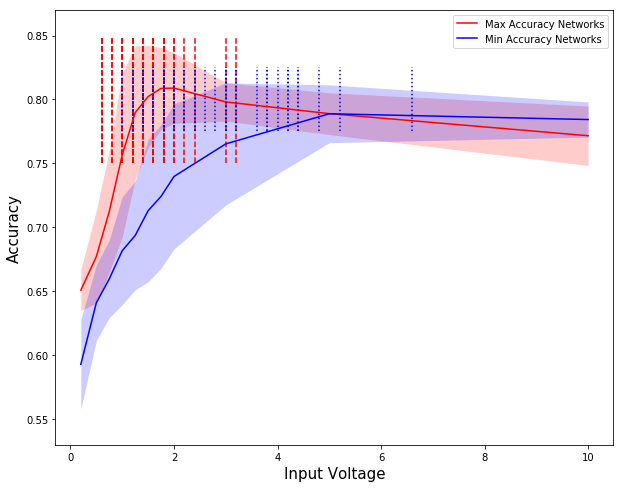

In [24]:
fig, ax1 = plt.subplots(figsize=(10,8))


plt.plot(xVals[0], avgMaxVolts, 'r-',label='Max Accuracy Networks')
plt.fill_between(xVals[0], avgMaxVolts-stdMaxVolts, avgMaxVolts+stdMaxVolts,alpha=0.2, edgecolor='#1B2ACC', facecolor='r',
    linewidth=0)

plt.vlines(np.asarray(Max_Vi),[0.75],[0.85],linestyles ='dashed',colors='r')

# ax2 = ax1.twinx()

plt.plot(xVals[0], avgMinVolts, 'b-',label='Min Accuracy Networks')
plt.fill_between(xVals[0], avgMinVolts-stdMinVolts, avgMinVolts+stdMinVolts,alpha=0.2, edgecolor='#1B2ACC', facecolor='b',
    linewidth=0)

plt.vlines(np.asarray(Min_Vi),[0.775],[0.825],linestyles ='dotted',colors='b')


plt.xlabel('Input Voltage',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.ylim([0.53,0.87])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50Min50Max Accuracy Networks Voltage Sweep w Error Bar.png',format='png',dpi=300)


In [25]:
# fig=plt.figure()
# ax=fig.add_subplot(1,1,1)

# colorsMin=[]
# for i in range(len(cmapMax)):
#     p=plt.plot(xVals[i],maxAcc[i],'-o',label='Max Accuracy networks')
#     p1=plt.plot(xVals[i],minAcc[i],'-o',label='Min Accuracy networks')
# handles, labels = ax.get_legend_handles_labels()

# # ax.set_xticks(range(11))
# # ax.set_xticklabels(onAmp_MinMax)
# plt.legend([handles[4],handles[-1]],[labels[0],labels[5]], loc = 'best')
# plt.xlabel('Input Voltage')
# plt.ylabel('Accuracy')

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50Min50Max Accuracy Networks Different Voltages scaled.png',format='png',dpi=300)


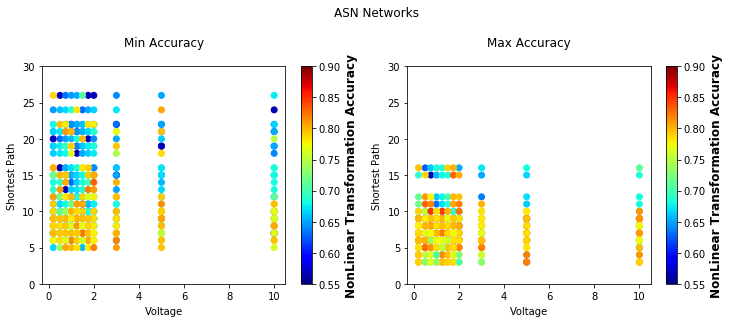

In [35]:
networkType='ASN'
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(12,4))
axBig = fig.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xticks([], [])
plt.yticks([], [])
axBig.set_frame_on(False)
plt.title(str(networkType)+' Networks',pad=50)

cmap=plt.cm.jet
vmin=0.55
vmax=0.9
normalize=plt.Normalize(vmin = vmin, vmax=vmax)

ax = fig.add_subplot(121)#, projection='3d')
yline=np.asarray([np.asarray(Min_shortestPath) for i in range(11)])
zline=np.asarray(minVolts) #accuracy
xline=np.asarray(xVals)

x=np.reshape(xline,(11,50))
y=np.reshape(yline,(11,50))
z=np.reshape(zline,(11,50))

colors1=[cmap(normalize(value)) for value in zline.reshape(550)]

ax.scatter(x, y,c=colors1,cmap=cmap)
ax.set_title('Min Accuracy',pad=20)
ax.set_xlabel('Voltage',labelpad=5)
# ax.set_zlabel('Accuracy',labelpad=5)
ax.set_ylabel('Shortest Path',labelpad=5)
ax.set_ylim([0, 30])
# ax.set_zlim([0.55, 0.9])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=ax)
cb.set_label(label='NonLinear Transformation Accuracy', size='large', weight='bold')

ax2 = fig.add_subplot(122)#, projection='3d')
yline=np.asarray([np.asarray(Max_shortestPath) for i in range(11)])
zline=np.asarray(maxVolts) #accuracy
xline=np.asarray(xVals)

x=np.reshape(xline,(11,50))
y=np.reshape(yline,(11,50))
z=np.reshape(zline,(11,50))
colors2=[cmap(normalize(value)) for value in zline.reshape(550)]

ax2.scatter(x, y,c=colors2,cmap=cmap)
ax2.set_title('Max Accuracy',pad=20)
ax2.set_xlabel('Voltage',labelpad=5)
# ax2.set_zlabel('Accuracy',labelpad=5)
ax2.set_ylabel('Shortest Path',labelpad=5)
ax2.set_ylim([0, 30])
# ax2.set_zlim([0.55, 0.9])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=ax2)
cb.set_label(label='NonLinear Transformation Accuracy', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50Min50Max Accuracy Networks Voltage Sweep vs Accuracy vs Shortest Path.png',format='png',dpi=300)


# random + grid

In [36]:
# name='WS_networks_LinearTransformation.pkl'
name='WS_Allnetworks_LinearTransformation.pkl'
print('Loading WS')
file = open(name, 'rb')
[WS_Grid,WS_Random] = pickle.load(file)
print('Loaded')

Loading WS
Loaded


In [37]:
#Calculate nodesList
nodesList_Random=[None]*len(WS_Random)
nodesList_Grid=[None]*len(WS_Grid)
for i in range(len(WS_Random)):
    if len(WS_Random[i]['G']) >= 250:
        nodesList_Random[i]=[50,100,150,200,250,len(WS_Random[i]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(WS_Random[i]['G']) >= 200 and len(WS_Random[i]['G']) < 250:
        nodesList_Random[i]=[50,100,150,200,len(WS_Random[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(WS_Random[i]['G']) >= 150 and len(WS_Random[i]['G']) < 200:
        nodesList_Random[i]=[50,100,150,len(WS_Random[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(WS_Random[i]['G']) >= 100 and len(WS_Random[i]['G']) < 150:
        nodesList_Random[i]=[50,100,len(WS_Random[i]['G'])]#range(50, len(ws300[i][0])+1,50)

for i in range(len(WS_Grid)):
    if len(WS_Grid[i]['G']) >= 250:
        nodesList_Grid[i]=[50,100,150,200,250,len(WS_Grid[i]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(WS_Grid[i]['G']) >= 200 and len(WS_Grid[i]['G']) < 250:
        nodesList_Grid[i]=[50,100,150,200,len(WS_Grid[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(WS_Grid[i]['G']) >= 150 and len(WS_Grid[i]['G']) < 200:
        nodesList_Grid[i]=[50,100,150,len(WS_Grid[i]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(WS_Grid[i]['G']) >= 100 and len(WS_Grid[i]['G']) < 150:
        nodesList_Grid[i]=[50,100,len(WS_Grid[i]['G'])]#range(50, len(ws300[i][0])+1,50)

In [38]:
RANDaccuracy=[[None]*len(WS_Random) for i in range(len(nodesList_Random[-1]))]
GRIDaccuracy=[[None]*len(WS_Grid) for i in range(len(nodesList_Grid[-1]))]


for i in range(len(WS_Random)): #for each parameter
    temp=[]
    for k in range(len(WS_Random[i]['Accuracy']['Linear Transformation'])):
        temp=WS_Random[i]['Accuracy']['Linear Transformation'][k]
        temp2=WS_Grid[i]['Accuracy']['Linear Transformation'][k]
        if k == 0:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
        elif k == 1:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
        elif k == 2:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
        elif k == 3:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
        elif k == 4:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
        elif k == 5:
            RANDaccuracy[k][i]=temp
            GRIDaccuracy[k][i]=temp2
                
#Find top 50 accuracy and bottom 50 accuracy networks
count=0
accuracy_rand=[None]*300
for i in range(len(RANDaccuracy[-1])):
    accuracy_rand[count]=RANDaccuracy[-1][i]
    count=count+1

idx_rand_acc=np.argsort(accuracy_rand)
accuracy_rand2=np.sort(accuracy_rand)
min_idx_rand_acc=idx_rand_acc[0:50]
min_rand_accuracy=accuracy_rand2[0:50]
max_idx_rand_acc=idx_rand_acc[-50:]
max_rand_accuracy=accuracy_rand2[-50:]

MaxRandAcc=max_idx_rand_acc     
MinRandAcc=min_idx_rand_acc    

#Find top 50 accuracy and bottom 50 accuracy networks 
#GRID
count=0
accuracy_grid=[None]*300
for i in range(len(GRIDaccuracy[-1])):
    accuracy_grid[count]=GRIDaccuracy[-1][i]
    count=count+1

idx_grid_acc=np.argsort(accuracy_grid)
accuracy_grid2=np.sort(accuracy_grid)
min_idx_grid_acc=idx_grid_acc[0:50]
min_grid_accuracy=accuracy_grid2[0:50]
max_idx_grid_acc=idx_grid_acc[-50:]
max_grid_accuracy=accuracy_grid2[-50:]

MaxGridAcc=max_idx_grid_acc     
MinGridAcc=min_idx_grid_acc      

In [39]:
Max_Min_Grid_NWS=np.hstack([MaxGridAcc, MinGridAcc])
Max_Min_Rand_NWS=np.hstack([MaxRandAcc, MinRandAcc])

In [40]:
#Shortest Path for 3D Plot
onAmp_RandVi=[]
shortestPath_Rand=[None]*len(WS_Random)
onAmp_GridVi=[]
shortestPath_Grid=[None]*len(WS_Random)
for i in tqdm(range(len(WS_Random))):
    temp=getFarthestPairing(WS_Random[i]['adj_matrix'])
    shortestPath_Rand[i]=nx.shortest_path_length(WS_Random[i]['G'],temp[0],temp[1])
    onAmp_RandVi.append(shortestPath_Rand[i]/5) #need to justify divide by 5 or come up with some other way
    
    temp2=getFarthestPairing(WS_Grid[i]['adj_matrix'])
    shortestPath_Grid[i]=nx.shortest_path_length(WS_Grid[i]['G'],temp2[0],temp2[1])
    onAmp_GridVi.append(shortestPath_Grid[i]/5) #need to justify divide by 5 or come up with some other way

In [41]:
MaxRand_shortestPath=[]
MinRand_shortestPath=[]
MaxRand_Vi=[]
MinRand_Vi=[]
MaxGrid_shortestPath=[]
MinGrid_shortestPath=[]
MaxGrid_Vi=[]
MinGrid_Vi=[]
for i in range(len(MaxRandAcc)):
    MaxRand_shortestPath.append(shortestPath_Rand[MaxRandAcc[i]])
    MinRand_shortestPath.append(shortestPath_Rand[MinRandAcc[i]])
    MaxRand_Vi.append(onAmp_RandVi[MaxRandAcc[i]])
    MinRand_Vi.append(onAmp_RandVi[MinRandAcc[i]])
    
    MaxGrid_shortestPath.append(shortestPath_Grid[MaxGridAcc[i]])
    MinGrid_shortestPath.append(shortestPath_Grid[MinGridAcc[i]])
    MaxGrid_Vi.append(onAmp_GridVi[MaxGridAcc[i]])
    MinGrid_Vi.append(onAmp_GridVi[MinGridAcc[i]])

In [42]:
def voltSweepWS(onAmp_MinMax,Max_Min_NWS,network,results_minMax,nodesList,i,j):
    #for each network
    stimulus=[[],[]]
    dt = 1e-2
    f=0.5
    Time=5

    #Choose Electrode Pattern

    stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp_MinMax[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    #Initialise Output Variables
    period=[]
    TimeVector=[]
    voltage=[]
    conductance=[]
    switches=[]
    # Voltage=[None]*len(ASN300)
    # Switches=[None]*len(ASN300)

    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#         if j < 50:
#             print('Voltage ' + str(onAmp_MinMax[i]) +', Max Accuracy ' + str(j))
#         else:
#             print('Voltage ' + str(onAmp_MinMax[i]) +', Min Accuracy'  + str(j))
    results_minMax=runSim(connectivity__(graph=network[Max_Min_NWS[j]]['G']),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp_MinMax[i], biasType='AC',f=f,junctionMode='tunneling')
     #100 simulations
    results_minMax.frequency=f
    results_minMax.dt=0.001
    period=1/f

    TimeVector=results_minMax.TimeVector
    voltage=results_minMax.wireVoltage
    conductance=results_minMax.conductance
    switches=results_minMax.junctionSwitch

    if len(network[Max_Min_NWS[j]]['G']) >= 250:
        nodesList=[50,100,150,200,250,len(network[Max_Min_NWS[j]]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(network[Max_Min_NWS[j]]['G']) >= 200 and len(network[Max_Min_NWS[j]]['G']) < 250:
        nodesList=[50,100,150,200,len(network[Max_Min_NWS[j]]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(network[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G']) >= 150 and len(network[Max_Min_NWS[j]]['G']) < 200:
        nodesList=[50,100,150,len(network[Max_Min_NWS[j]]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(network[Max_Min_NWS[j]]['G']) >= 100 and len(network[Max_Min_NWS[j]]['G']) < 150:
        nodesList=[50,100,len(network[Max_Min_NWS[j]]['G'])]#range(50, len(ws300[i][0])+1,50)

    nwSqu =[None]*len(nodesList)

    target1= (onAmp_MinMax[i] * (-np.sign(TimeVector % period - period/2)))

    countK=0
    for k in nodesList: #loop through sets of nodes for regression
        print('Running Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_minMax,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)

    # OLD WAY: NOKEVregression(target1[j],nwOutputs[j].T)[0]
    # OLD WAY: outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
    # temp=np.dot(outputx,ResultSqu)
    # MSE=np.mean((target1[j]-temp)**2)
    # rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
        nwSqu[countK]=ResultSqu['accuracy']
        countK=countK+1   
    return nwSqu
#     name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50_Max_Min_NWs_Simulations_Voltage_' + str(onAmp_MinMax[i])
#     print('Saving Simulations for Voltage ' +str(i+1))
#     compressed_pickle([results_minMax],name)

In [43]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_WSnetworks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    initGridMax=[]
    initGridMin=[]
    for i in tqdm(range(len(onAmp_MinMax))): #for each voltage
        results_Grid_minMax=[None]*len(Max_Min_Grid_NWS)
        nodesList=[None]*len(Max_Min_Grid_NWS)
        for j in range(len(Max_Min_Grid_NWS)): #for each network
            if j<50:
                initGridMax.append(inputPacker(voltSweepWS,onAmp_MinMax,Max_Min_Grid_NWS,WS_Grid,results_Grid_minMax,nodesList,i,j))
            else:
                initGridMin.append(inputPacker(voltSweepWS,onAmp_MinMax,Max_Min_Grid_NWS,WS_Grid,results_Grid_minMax,nodesList,i,j))

In [44]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_WSnetworks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    initRandMax=[]
    initRandMin=[]
    for i in tqdm(range(len(onAmp_MinMax))): #for each voltage
        results_Rand_minMax=[None]*len(Max_Min_Rand_NWS)
        nodesList=[None]*len(Max_Min_Rand_NWS)
        for j in range(len(Max_Min_Rand_NWS)): #for each network
            if j<50:
                initRandMax.append(inputPacker(voltSweepWS,onAmp_MinMax,Max_Min_Rand_NWS,WS_Random,results_Rand_minMax,nodesList,i,j))
            else:
                initRandMin.append(inputPacker(voltSweepWS,onAmp_MinMax,Max_Min_Rand_NWS,WS_Random,results_Rand_minMax,nodesList,i,j))

In [45]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_WSnetworks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    resultGridMax=para_run(voltSweepWS,initGridMax,nCPU=20)   
    resultGridMin=para_run(voltSweepWS,initGridMin,nCPU=20)   

In [46]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_WSnetworks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    resultRandMax=para_run(voltSweepWS,initRandMax,nCPU=20)   
    resultRandMin=para_run(voltSweepWS,initRandMin,nCPU=20)  

In [47]:
#Save networks so we don't have to run this every time   
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/50MaxMin_WSnetworks_LinearTransformation.pkl'
if (not os.path.isfile(name)): #if we haven't saved the file
    print('Saving Max Min Random + Grid Accuracies')
    with open(name, 'wb') as f:
        pickle.dump([resultRandMax,resultRandMin,resultGridMax,resultGridMin], f)   
else:
    print('Loading Random + Grid Max Min Accuracies')
    file = open(name, 'rb')
    [resultRandMax,resultRandMin,resultGridMax,resultGridMin] = pickle.load(file)
    print('Loaded')

Loading Random + Grid Max Min Accuracies
Loaded


In [48]:
networkType='Random'#'Grid'#

In [49]:
maxAcc=[]
minAcc=[]
if networkType=='Random':
    for i in range(len(resultRandMax)): #for each network:
        tempMax=np.max(resultRandMax[i])
        tempMin=np.max(resultRandMin[i])
        maxAcc.append(tempMax)
        minAcc.append(tempMin)

    maxAcc=np.vstack(maxAcc).reshape(11,50)
    minAcc=np.vstack(minAcc).reshape(11,50)
    MaxVi=MaxRand_Vi
    MinVi=MinRand_Vi
elif networkType=='Grid':
    for i in range(len(resultGridMax)): #for each network:
        tempMax=np.max(resultGridMax[i])
        tempMin=np.max(resultGridMin[i])
        maxAcc.append(tempMax)
        minAcc.append(tempMin)

    maxAcc=np.vstack(maxAcc).reshape(11,50)
    minAcc=np.vstack(minAcc).reshape(11,50)
    MaxVi=MaxGrid_Vi
    MinVi=MinGrid_Vi

In [50]:
vol1=[];vol2=[];vol3=[];vol4=[];vol5=[];vol6=[];vol7=[];vol8=[];vol9=[];vol10=[];vol11=[];
vol1_max=[];vol2_max=[];vol3_max=[];vol4_max=[];vol5_max=[];vol6_max=[];vol7_max=[];vol8_max=[];vol9_max=[];vol10_max=[];
vol11_max=[];

for i in range(len(minAcc)):
    for j in range(len(minAcc[i])):
        if i==0:
            vol1_max.append(maxAcc[i][j])
            vol1.append(minAcc[i][j])
        elif i == 1:
            vol2_max.append(maxAcc[i][j])
            vol2.append(minAcc[i][j])
        elif i == 2:
            vol3_max.append(maxAcc[i][j])
            vol3.append(minAcc[i][j])
        elif i == 3:
            vol4_max.append(maxAcc[i][j])
            vol4.append(minAcc[i][j])
        elif i == 4:
            vol5_max.append(maxAcc[i][j])
            vol5.append(minAcc[i][j])
        elif i == 5:
            vol6_max.append(maxAcc[i][j])
            vol6.append(minAcc[i][j])
        elif i == 6:
            vol7_max.append(maxAcc[i][j])
            vol7.append(minAcc[i][j])
        elif i == 7:
            vol8_max.append(maxAcc[i][j])
            vol8.append(minAcc[i][j])
        elif i == 8:
            vol9_max.append(maxAcc[i][j])
            vol9.append(minAcc[i][j])
        elif i == 9:
            vol10_max.append(maxAcc[i][j])
            vol10.append(minAcc[i][j])
        elif i == 10:
            vol11_max.append(maxAcc[i][j])
            vol11.append(minAcc[i][j])
    

In [51]:
cmap1=plt.cm.get_cmap('Reds')
cmap2=plt.cm.get_cmap('Blues')
cmapMax=[cmap1(i) for i in range(50,255,50)]
cmapMin=[cmap2(i) for i in range(50,255,50)]

In [52]:
#find mean and std of all networks voltages:
maxVolts=np.vstack((vol1_max, vol2_max, vol3_max, vol4_max, vol5_max, vol6_max, vol7_max, vol8_max,vol9_max,vol10_max,vol11_max))
minVolts=np.vstack((vol1, vol2, vol3, vol4, vol5, vol6, vol7, vol8,vol9,vol10,vol11))

avgMaxVolts=np.mean(maxVolts,axis=1)
stdMaxVolts=np.std(maxVolts,axis=1)
avgMinVolts=np.mean(minVolts,axis=1)
stdMinVolts=np.std(minVolts,axis=1)

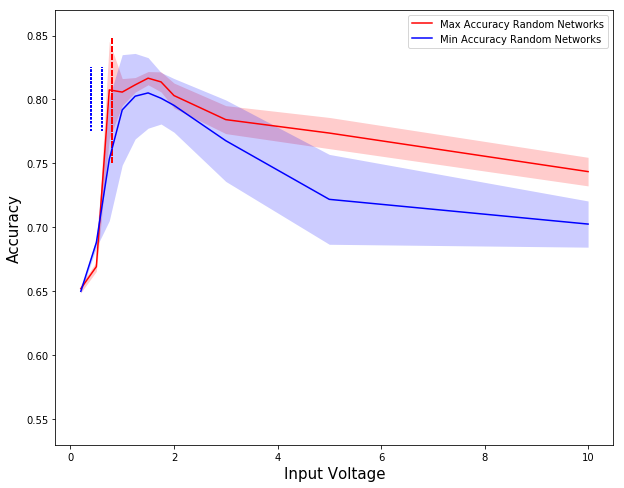

In [53]:
fig=plt.figure(figsize=(10,8))

xVals=[np.asarray(onAmp_MinMax) for i in range(len(maxVolts[0]))]

plt.plot(xVals[0], avgMaxVolts, 'r-',label='Max Accuracy '+ str(networkType) +' Networks')
plt.fill_between(xVals[0], avgMaxVolts-stdMaxVolts, avgMaxVolts+stdMaxVolts,alpha=0.2, edgecolor='#1B2ACC', facecolor='r',
    linewidth=0)

plt.vlines(np.asarray(MaxVi),[0.75],[0.85],linestyles ='dashed',colors='r')

plt.plot(xVals[0], avgMinVolts, 'b-',label='Min Accuracy '+ str(networkType) +' Networks')
plt.fill_between(xVals[0], avgMinVolts-stdMinVolts, avgMinVolts+stdMinVolts,alpha=0.2, edgecolor='#1B2ACC', facecolor='b',
    linewidth=0)

plt.vlines(np.asarray(MinVi),[0.775],[0.825],linestyles ='dotted',colors='b')

plt.xlabel('Input Voltage',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend()
plt.ylim([0.53,0.87])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50Min50Max Accuracy '+ str(networkType) +' Networks Voltage Sweep w Error Bar.png',format='png',dpi=300)


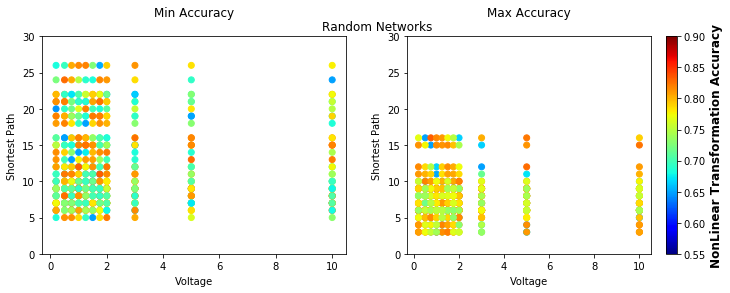

In [58]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(12,4))
axBig = fig.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xticks([], [])
plt.yticks([], [])
axBig.set_frame_on(False)
plt.title(str(networkType)+' Networks')


vmin=0.55
vmax=0.9
normalize=plt.Normalize(vmin = vmin, vmax=vmax)

ax = fig.add_subplot(121)#, projection='3d')
yline=np.asarray([np.asarray(Min_shortestPath) for i in range(11)])
zline=np.asarray(minVolts) #accuracy
xline=np.asarray(xVals)
cmap=plt.cm.jet
colors1=[cmap(normalize(value)) for value in zline.reshape(550)]


x=np.reshape(xline,(11,50))
y=np.reshape(yline,(11,50))
z=np.reshape(zline,(11,50))

ax.scatter(x, y,c=colors1,cmap=cmap)
ax.set_title('Min Accuracy',pad=20)
ax.set_xlabel('Voltage',labelpad=5)
# ax.set_zlabel('Accuracy',labelpad=5)
ax.set_ylabel('Shortest Path',labelpad=5)
ax.set_ylim([0, 30])
# ax.set_zlim([0.55, 0.9])


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=ax2)
cb.set_label(label='NonLinear Transformation Accuracy', size='large', weight='bold')

ax2 = fig.add_subplot(122)#, projection='3d')
yline=np.asarray([np.asarray(Max_shortestPath) for i in range(11)])
zline=np.asarray(maxVolts) #accuracy
xline=np.asarray(xVals)
x=np.reshape(xline,(11,50))
y=np.reshape(yline,(11,50))
z=np.reshape(zline,(11,50))

colors2=[cmap(normalize(value)) for value in zline.reshape(550)]

ax2.scatter(x, y,c=colors2,cmap=cmap)
ax2.set_title('Max Accuracy',pad=20)
ax2.set_xlabel('Voltage',labelpad=5)
# ax2.set_zlabel('Accuracy',labelpad=5)
ax2.set_ylabel('Shortest Path',labelpad=5)
ax2.set_ylim([0, 30])
# ax2.set_zlim([0.55, 0.9])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb=plt.colorbar(sm,ax=ax2)
cb.set_label(label='NonLinear Transformation Accuracy', size='large', weight='bold')


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50Min50Max Accuracy '+ str(networkType) +' Networks Voltage vs Accuracy vs Shortest Path.png',format='png',dpi=300)
